Demonstrate orbit propagation (OP) using Cowell's method.

Example: ISS TLE file downloaded from celestrak.com on 3 August 2017

ISS (ZARYA)

1 25544U 98067A 17213.83387828 .00000874 00000-0 20415-4 0 9996

2 25544 51.6427 170.7730 0006301 93.4612 353.3163 15.54246517 68858

@author: Ashiv Dhondea

Created on 10 August 2017


In [1]:
# Load the libraries required
import AstroConstants as AstCnst
import AstroFunctions as AstFn
import DynamicsFunctions as DynFn
import MathsFunctions as MathsFn
import Num_Integ as Integ

import math
import numpy as np

# Importing what's needed for nice plots.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Helvetica']}); 
rc('text', usetex=True)
params = {'text.latex.preamble' : [r'\usepackage{amsmath}', r'\usepackage{amssymb}']}
plt.rcParams.update(params)

# Matplotlib inline. Comment out if you don't want inline plots.
%matplotlib inline

# Libraries related to time keeping and formatting.
import datetime as dt
import pytz
import aniso8601

In [2]:
# Place the contents of the TLE file here.
## ISS (ZARYA)                        
tle_line1 = '1 25544U 98067A   17213.83387828  .00000874  00000-0  20415-4 0  9996';
tle_line2 = '2 25544  51.6427 170.7730 0006301  93.4612 353.3163 15.54246517 68858';

In [3]:
# Read the Keplerians as well as the epoch of validity of the TLE file
a,e,i,BigOmega,omega,E,nu,epoch  = AstFn.fnTLEtoKeps(tle_line1,tle_line2);

In [4]:
print 'semi-major axis in [km]' 
print a
print 'eccentricity' 
print e
print 'inclination in [deg]' 
print i
print 'RAAN in [deg]' 
print BigOmega
print 'argument of perigee in [deg]' 
print omega
print 'true anomaly in [deg]' 
print math.degrees(nu)
print 'epoch' 
print epoch

semi-major axis in [km]
6782.48079627
eccentricity
0.0006301
inclination in [deg]
51.6427
RAAN in [deg]
170.773
argument of perigee in [deg]
93.4612
true anomaly in [deg]
96.4355054078
epoch
17213.83387828


In [5]:
# Calculate epoch at which the TLE was valid
year,dayy, hrs, mins, secs, millisecs = AstFn.fn_Calculate_Epoch_Time(epoch);
todays_date = AstFn.fn_epoch_date(year,dayy);
print "TLE epoch date is", todays_date
print "UTC time = ",hrs,"h",mins,"min",secs+millisecs,"s"

TLE epoch date is 2017-08-01
UTC time =  20 h 0 min 47.083392 s


In [6]:
# Create a datetime object for the epoch of validity
timestamp_tle_epoch = dt.datetime(year=todays_date.year,month=todays_date.month,day=todays_date.day,hour=hrs,minute=mins,second=secs,microsecond=int(millisecs),tzinfo= pytz.utc)

In [7]:
# Convert Keplerians to Cartesian state vector
xstate = AstFn.fnKepsToCarts(a,e, math.radians(i), math.radians(omega),math.radians(BigOmega),nu);
print 'ECI state vector read from TLE file'
print xstate

ECI state vector read from TLE file
[  6.71156486e+03  -3.57343479e+02  -9.14171985e+02  -5.44290159e-01
   4.83654902e+00  -5.92219633e+00]


In [8]:
# Find Kepler period
T = AstFn.fnKeplerOrbitalPeriod(a);
print "the Kepler period is %f min" %(T/60.)

the Kepler period is 92.649395 min


In [9]:
# time step for simulation
delta_t = 1; #[s]
# duration of simulation.
# here, we have chosen to simulate the orbit over two orbits, at a constant time step of delta_t
timevec = np.arange(0,T*2 +delta_t,delta_t,dtype=np.float64);
# state vectors in the ECI frame. contain x, y, z position and x, y, z velocity in [km] & [km/s]
x_state = np.zeros([6,len(timevec)],dtype=np.float64);
# position state vectors in the ECEF frame
xecef = np.zeros([3,len(timevec)],dtype=np.float64);
# Latitude & longitude of the ground track
lat = np.zeros([len(timevec)],dtype=np.float64);
lon = np.zeros([len(timevec)],dtype=np.float64);

In [10]:
index = 0;
x_state[:,index] = xstate; # load initial conditions to the Initial Value Problem
theta_GMST =  math.radians(AstFn.fn_Convert_Datetime_to_GMST(timestamp_tle_epoch));        
## Rotate ECI position vector by GMST angle to get ECEF position
theta_GMST = AstFn.fnZeroTo2Pi(theta_GMST);
xecef[:,index] = AstFn.fnECItoECEF(x_state[0:3,index],theta_GMST);
lat[index],lon[index] = AstFn.fnCarts_to_LatLon(xecef[:,index]); # convert Cartesian position vector to latitude, longitude

for index in range(1,len(timevec)):
    # Read the time and figure out the timestamps for each time instant
    current_time = timevec[index];
    hrs,mins,secs = AstFn.fnSeconds_To_Hours(current_time + (timestamp_tle_epoch.hour*60*60) + (timestamp_tle_epoch.minute*60)+ timestamp_tle_epoch.second);
    dys = timestamp_tle_epoch.day + int(math.ceil(hrs/24)); 
    if hrs >= 24:
        hrs = hrs - 24*int(math.ceil(hrs/24)) ;
    # Perform the RK4 simulation step
    x_state[:,index] = Integ.fnRK4_vector(DynFn.fnKepler_J2, delta_t, x_state[:,index-1],timevec[index]);
    # Find the epoch object & figure out the GMST angle from the epoch
    tle_epoch_test = dt.datetime(year=timestamp_tle_epoch.year,month=timestamp_tle_epoch.month,day=int(dys),hour=int(hrs),minute=int(mins),second=int(secs),microsecond=0,tzinfo= pytz.utc);
    theta_GMST =  math.radians(AstFn.fn_Convert_Datetime_to_GMST(tle_epoch_test));        
    ## Rotate ECI position vector by GMST angle to get ECEF position
    theta_GMST = AstFn.fnZeroTo2Pi(theta_GMST);
    xecef[:,index] = AstFn.fnECItoECEF(x_state[0:3,index],theta_GMST);
    lat[index],lon[index] = AstFn.fnCarts_to_LatLon(xecef[:,index]);# convert Cartesian position vector to latitude, longitude

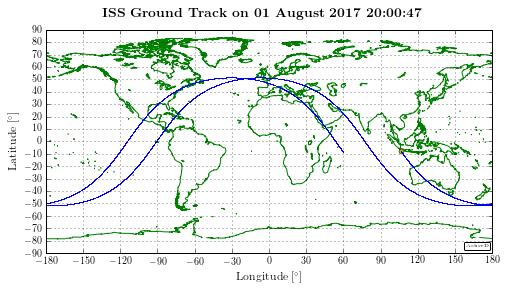

In [11]:
# plot results     
coastline_data= np.loadtxt('Coastline.txt',skiprows=1)
w, h = plt.figaspect(0.5)
fig = plt.figure(figsize=(w,h))
ax = fig.gca()
plt.rc('text', usetex=True)
plt.rc('font', family='serif');
plt.rc('font',family='helvetica');
params = {'legend.fontsize': 8,
    'legend.handlelength': 2}
plt.rcParams.update(params)

groundtrack_title = timestamp_tle_epoch.strftime('%d %B %Y %H:%M:%S')
fig.suptitle(r"\textbf{ISS Ground Track on %s}" %groundtrack_title,fontsize=14)
plt.plot(coastline_data[:,0],coastline_data[:,1],'g');
ax.set_xlabel(r'Longitude $[\mathrm{^\circ}]$',fontsize=12)
ax.set_ylabel(r'Latitude $[\mathrm{^\circ}]$',fontsize=12)
plt.xlim(-180,180);
plt.ylim(-90,90);
plt.yticks([-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90]);
plt.xticks([-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180]);
plt.plot(math.degrees(lon[0]),math.degrees(lat[0]),'yo',markersize=5,label=timestamp_tle_epoch.isoformat() + 'Z');
for index in range(1,len(timevec)-1):
    plt.plot(math.degrees(lon[index]),math.degrees(lat[index]),'b.',markersize=1);

ax.grid(True);

at = AnchoredText("AshivD",prop=dict(size=5), frameon=True,loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
plt.show()